In [2]:
ON_COLAB = True

if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
# other
import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path
import pandas as pd
import imageio
from csv import writer
from PIL import Image
from tqdm.notebook import tqdm

# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

In [4]:
# Turn the folder of txt files in csv file
txt_path = 'drive/Othercomputers/Il mio laptop/baseline/poses_txt'

def get_nth_line(fobj, n):
    for i in range(n):
        next(fobj)
    return next(fobj)

columns = ['id', 'x', 'y', 'z', 'roll', 'pitch', 'yaw']

with open('drive/Othercomputers/Il mio laptop/baseline/poses.csv', 'w') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(columns)
    for f in Path(txt_path).iterdir():
        id = int(str(f).split('/')[-1].split('.txt')[0]) 
        file = open(f)
        line4 = get_nth_line(file, 4)
        line_splitted = line4.split(' ')
        writer_object.writerow([id] + line_splitted)
    f_object.close()

In [45]:
class PoseDataset(Dataset):

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        poses = pd.read_csv(csv_file)
        print(type(poses.iloc[0, 0]))
        self.poses = poses.sort_values(by=["id"])
        print('self.poses', self.poses)
        print(self.poses.iloc[0, 0])
        self.root_dir = root_dir
    

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                str(self.poses.iloc[idx, 0]) + '-N_.png')
        
        img = imageio.imread(img_path, ignoregamma = True)
        rgb_img = img[:,:,:3]
        img_tensor = torch.tensor(rgb_img)/255.0
        img_tensor = np.transpose(img_tensor, (2, 0, 1))
        #print('img_tensor', img_tensor.shape)

        #img_downsampled = F.upsample(img_tensor, size_new=(256,256), mode=bilinear)
        img_downsampled = F.interpolate(img_tensor, scale_factor = 0.25)
        img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
        img_downsampled = F.interpolate(img_downsampled, scale_factor = 0.25)
        img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
        #print('img_downsampled', img_downsampled.shape)
        
        '''img2 = Image.open(img_path)
        rgb_img2 = img2.convert('RGB')
        transform = transforms.Compose([transforms.ToTensor()])
        img2_tensor = transform(rgb_img2)'''

        pose = self.poses.iloc[idx, 1:]
        pose = np.array([pose])
        pose =  pose.reshape(6)      
        return img_downsampled, pose

In [46]:
pose_dataset = PoseDataset(csv_file = 'drive/Othercomputers/Il mio laptop/baseline/poses.csv',
                           root_dir='drive/Othercomputers/Il mio laptop/baseline/RGB_images')

<class 'numpy.int64'>
self.poses         id           x           y           z        roll      pitch  \
9000     0  303.329285   89.407677  -11.472251 -104.222527 -72.607857   
9001     1  219.377014  -73.048820   47.229362 -125.215286 -71.151596   
8113     2  164.365097  -23.056631  -17.131699 -110.821266 -70.219131   
7224     3  145.490479   34.552158   62.102009  -89.446541 -73.435089   
6335     4  299.769043  -25.140842 -134.065094 -156.339081 -49.468636   
...    ...         ...         ...         ...         ...        ...   
995   9994  352.079498 -133.376587  -81.269363  -96.516602  46.526745   
996   9995  261.693085  -21.329548   13.556644  -64.263023  55.276627   
997   9996  274.697083  -83.636955   45.960495  -82.570702  53.964485   
998   9997  248.191940   43.430157  -49.240246  -76.723022  67.937775   
999   9998  284.248688  139.672806   17.611832  -71.257584  66.235634   

             yaw  
9000  109.514580  
9001  118.683220  
8113  125.833733  
7224   94.1438

In [47]:
print('pose_dataset', pose_dataset[0])
'''img, pose = pose_dataset[0]
print(pose)
plt.figure()
plt.imshow(img)
plt.show()'''

pose_dataset (tensor([[[0.6784, 0.3647, 0.2824,  ..., 0.0000, 0.0000, 0.0000],
         [0.8980, 0.5804, 0.2510,  ..., 0.0000, 0.0000, 0.0000],
         [0.9294, 0.8353, 0.4118,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0275, 0.0275, 0.0275,  ..., 0.0000, 0.0000, 0.0000],
         [0.0275, 0.0235, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
         [0.0275, 0.0235, 0.0235,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.7098, 0.4863, 0.4275,  ..., 0.0000, 0.0000, 0.0000],
         [0.8980, 0.6314, 0.3882,  ..., 0.0000, 0.0000, 0.0000],
         [0.9333, 0.8431, 0.4980,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1569, 0.1529, 0.1490,  ..., 0.0000, 0.0000, 0.0000],
         [0.1490, 0.1451, 0.1373,  ..., 0.0000, 0.0000, 0.0000],
         [0.1412, 0.1373, 0.1373,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.7137, 0.5098, 0.3098,  ..., 0.0000, 0.0000, 0.0000],
         [0.8980, 0.6745, 0.3608,  ..., 0.0000, 0.0000, 0.0000],
         [0.9294, 0.8392, 0.5451,  ..., 0.00

'img, pose = pose_dataset[0]\nprint(pose)\nplt.figure()\nplt.imshow(img)\nplt.show()'

In [56]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean.tolist(), std.tolist()),
    ]
)

# Create train val test split
n = len(pose_dataset)
n_1 = int(n/10)

train_set, val_set, test_set = torch.utils.data.random_split(
    pose_dataset, [n-(2*n_1), n_1, n_1])
print('train_set', train_set)

print(len(train_set), len(val_set), len(test_set))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number!
batch_size = 64

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
print('loader_val', loader_val)
loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)


train_set <torch.utils.data.dataset.Subset object at 0x7f666024a050>
8001 999 999
loader_val <torch.utils.data.dataloader.DataLoader object at 0x7f66603c5810>


In [57]:
### TO DO ### UNDERSTAND IF THE MEAN AND STD SHOULD BE DIFFERENT WRT THE OTHER EXAMPLE AND IF YES HOW

unnormalize = transforms.Normalize(
    (-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).clip(0, 1))


In [65]:
# define resnet2 building blocks

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))
        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding=0, bias=False),
                                          nn.BatchNorm2d(outchannel))

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# define resnet

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=6):
        super(ResNet, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=1)
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.maxpool2 = nn.MaxPool2d(2, stride=1, padding=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        #print('x_shape', x.shape)
        x = self.conv1(x)
        #print('x_shape', x.shape)
        x = self.maxpool(x)
        #print('x_shape', x.shape)
        x = self.layer1(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer2(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer3(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer4(x)
        #print('x_shape', x.shape)
        x = self.avgpool(x)
        #print('x_shape', x.shape)
        x = x.view(x.size(0), -1)
        #print('x_shape', x.shape)
        x = self.fc(x)
        #print('x_shape', x.shape)
        return x

# please do not change the name of this class
# Got 1315 / 1998 correct of val set (65.82)

def MyResNet():
    return ResNet(ResidualBlock)

In [71]:
USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

print_every = 10

def train_part(model, optimizer, epochs=1):
    """
    Train a model on NaturalImageNet using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    iter_val = iter(loader_val)
    losses = []
    val_losses = []

    for e in tqdm(range(epochs)):
        #counts = torch.zeros((20,), device=device, dtype=torch.long)
        for t, (x, y) in enumerate(tqdm(loader_train, leave=False)):

            try:
                x_val, y_val = next(iter_val)
            except StopIteration:
                iter_val = iter(loader_val)
                x_val, y_val = next(iter_val)

            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #print('x', x)
            y = y.to(device=device, dtype=torch.float32)
            #print('y', y)

            x_val = x_val.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y_val = y_val.to(device=device, dtype=torch.float32)
            
            #counts.index_add_(0,torch.unique(y, return_counts=True)[0],torch.unique(y, return_counts=True)[1])

            scores = model(x)
            #print('scores', scores)
            loss = F.mse_loss(scores, y)
            #print('loss', loss)
            losses.append(loss.item())

            scores_val = model(x_val)
            #print('scores_val', scores)
            val_loss = F.mse_loss(scores_val, y_val)
            #print('val_loss', loss)
            val_losses.append(val_loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            
            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                
        #check_accuracy(loader_val, model)

        #print("data counts", counts/torch.sum(counts))

    plt.figure(figsize=(10,7))
    plt.title("Learning curve")
    plt.plot(losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.legend()
    plt.savefig('learning_curve.png', bbox_inches='tight', dpi=150)
    plt.show()


cuda:0


Total number of parameters is: 11183814


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 0, Iteration 0, loss = 16653.4414
Epoch: 0, Iteration 10, loss = 14146.3418
Epoch: 0, Iteration 20, loss = 11806.5586
Epoch: 0, Iteration 30, loss = 12827.1094
Epoch: 0, Iteration 40, loss = 11632.6592
Epoch: 0, Iteration 50, loss = 11119.4824
Epoch: 0, Iteration 60, loss = 9568.0430
Epoch: 0, Iteration 70, loss = 8622.8916
Epoch: 0, Iteration 80, loss = 8346.6934
Epoch: 0, Iteration 90, loss = 7635.8623
Epoch: 0, Iteration 100, loss = 6927.0664
Epoch: 0, Iteration 110, loss = 6551.7925
Epoch: 0, Iteration 120, loss = 6841.0225


  0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 1, Iteration 0, loss = 5450.9419
Epoch: 1, Iteration 10, loss = 3663.2896
Epoch: 1, Iteration 20, loss = 4019.2859
Epoch: 1, Iteration 30, loss = 3842.1042
Epoch: 1, Iteration 40, loss = 3936.4795
Epoch: 1, Iteration 50, loss = 3842.9597
Epoch: 1, Iteration 60, loss = 2509.9888
Epoch: 1, Iteration 70, loss = 2585.5015
Epoch: 1, Iteration 80, loss = 2394.9839
Epoch: 1, Iteration 90, loss = 2239.4905
Epoch: 1, Iteration 100, loss = 1551.8867
Epoch: 1, Iteration 110, loss = 2270.4385
Epoch: 1, Iteration 120, loss = 1082.2241


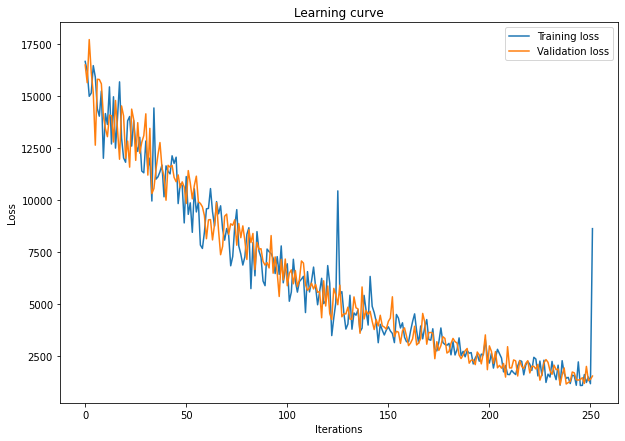

In [70]:
# define and train the network
torch.autograd.set_detect_anomaly(True)
model = MyResNet()
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-7)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs=2)

losses = []
val_losses = []

# report test set accuracy
#check_accuracy(loader_val, model, analysis=True)

# save the model
torch.save(model.state_dict(), 'model.pt')


In [ ]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)
